# Image Segmentation

# How It Works:
- **Binary Thresholding:** Converts the image to a binary form using a fixed threshold.
- **Adaptive Thresholding:** Applies a locally adaptive threshold, useful for uneven lighting conditions.
- **Otsu's Thresholding**: Automatically calculates an optimal threshold value for the image.
- **Canny Edge Detection:** Detects edges based on gradients in the image.
- **Watershed Algorithm:** Segments regions using distance transformations and connected components.

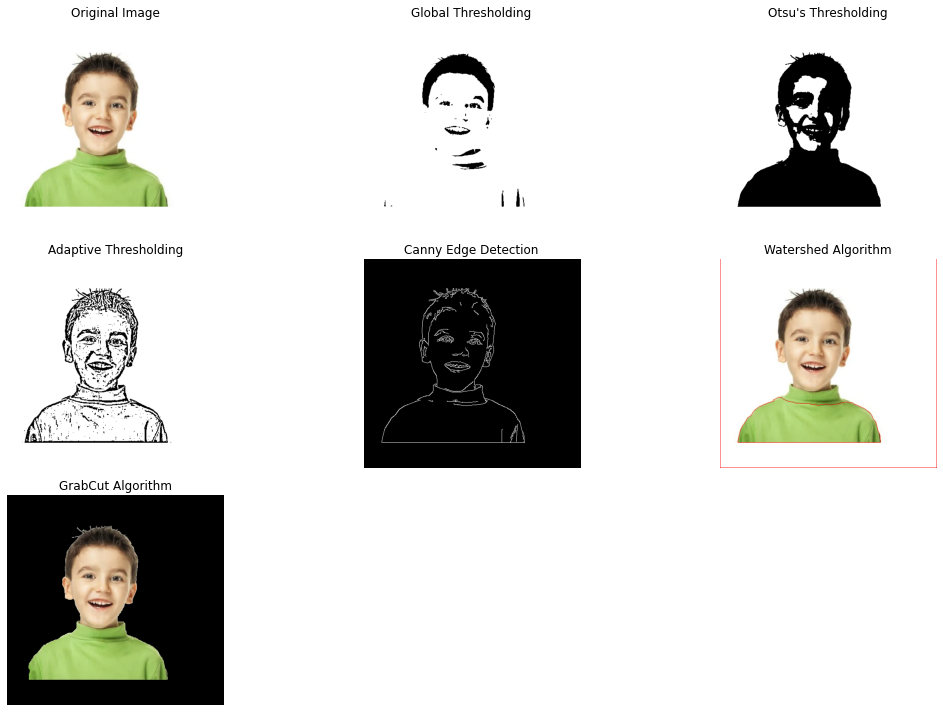

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the input image
image = cv2.imread('seg 2.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Convert to grayscale for methods that require it
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 1. Global Thresholding
_, thresh_binary = cv2.threshold(src=gray, thresh=127, maxval=255, cv2.THRESH_BINARY)

# 2. Otsu's Thresholding
_, thresh_otsu = cv2.threshold(src=gray, thresh=0, maxval=255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3. Adaptive Thresholding
thresh_adaptive = cv2.adaptiveThreshold(src=gray, maxValue=255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, blockSize=11, 2)

# 4. Canny Edge Detection
canny_edges = cv2.Canny(gray, 100, 200)

# 5. Watershed Algorithm
# Create a binary image using thresholding
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(src=binary, op=cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
image_markers = image.copy()
markers = cv2.watershed(image_markers, markers)
watershed_result = image_rgb.copy()
watershed_result[markers == -1] = [255, 0, 0]  # Mark boundaries with red

# 6. GrabCut Algorithm
mask = np.zeros(image.shape[:2], np.uint8)
bg_model = np.zeros((1, 65), np.float64)
fg_model = np.zeros((1, 65), np.float64)
rect = (50, 50, image.shape[1] - 100, image.shape[0] - 100)  # Rectangle around the object
cv2.grabCut(image, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
grabcut_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
grabcut_result = image_rgb * grabcut_mask[:, :, np.newaxis]

# Display all results
methods = [
    ("Original Image", image_rgb),
    ("Global Thresholding", thresh_binary),
    ("Otsu's Thresholding", thresh_otsu),
    ("Adaptive Thresholding", thresh_adaptive),
    ("Canny Edge Detection", canny_edges),
    ("Watershed Algorithm", watershed_result),
    ("GrabCut Algorithm", grabcut_result)
]

# Plot the results for comparison
plt.figure(figsize=(15, 10))
for i, (title, result) in enumerate(methods):
    plt.subplot(3, 3, i + 1)
    if len(result.shape) == 2:  # Grayscale image
        plt.imshow(result, cmap='gray')
    else:  # RGB image
        plt.imshow(result)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()